<a href="https://colab.research.google.com/github/QiaoLin22/MASTER-LLM-DL/blob/main/llama3_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tiktoken
!pip install blobfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.8 MB/s eta 0:00:00


In [3]:
!pip install llama-stack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.0/333.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=6917cc6a91cf4c3f49b7968a1e586dcbdf040fa8168750c5cf1956c79db85292
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [4]:
!llama model list

+-----------------------------------------+-----------------------------------------------------+----------------+
| Model Descriptor                        | Hugging Face Repo                                   | Context Length |
+-----------------------------------------+-----------------------------------------------------+----------------+
| Llama3.1-8B                             | meta-llama/Llama-3.1-8B                             | 128K           |
+-----------------------------------------+-----------------------------------------------------+----------------+
| Llama3.1-70B                            | meta-llama/Llama-3.1-70B                            | 128K           |
+-----------------------------------------+-----------------------------------------------------+----------------+
| Llama3.1-405B:bf16-mp8                  | meta-llama/Llama-3.1-405B                           | 128K           |
+-----------------------------------------+-------------------------------------

In [5]:
!llama download --source meta --model-id Llama3.1-8B

Please provide the signed URL for model Llama3.1-8B you received via email after visiting https://www.llama.com/llama-downloads/ (e.g., https://llama3-1.llamameta.net/*?Policy...): https://llama3-1.llamameta.net/*?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoibHFxeXIycXB3dHk3NXFscGh2ZjZyeHptIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvbGxhbWEzLTEubGxhbWFtZXRhLm5ldFwvKiIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMTYxNTE2Nn19fV19&Signature=rKz-AtAbHGDC5b2SKpxwCEh5PTExAjbmtvVGo64a2YHYYilGkvmorOz6xNW2dVYyEszldsJsPYMEHZhrEvQ9Hm%7EsthIsudyRuospbYU8MAwXCg71ODQQdmIMclxOYvCabeWRVwC-DtHKDITUN5mnXt12KNNcfeAF8BnUEZVlKtVw2x9BQ2kwCbRTpKloWgKD4rqCBsgqBEO93axIOWZtAVODlQlz2hIjwapVaZvHVbHhvB7ME6v3BK1lTOmciaB1ZwZr498ZFbgeTC8xE51-dGCje61x5yINR9hplZKYHIAi8jigre8DLpCiEGdQwjSlL92a5E-G34fn25uX-tlMMg__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1098074802020669
Progress: |██████████████████████████████████████████████████| 100.00% (0/0 MB) Speed: 0.00 MiB/s
Finished downloading `/root/.llama/chec

In [6]:
!cd /root/.llama/checkpoints/Llama3.1-8B
!ls /root/.llama/checkpoints/Llama3.1-8B

checklist.chk  consolidated.00.pth  params.json  tokenizer.model


In [8]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "/root/.llama/checkpoints/Llama3.1-8B/tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

In [9]:
model = torch.load("/root/.llama/checkpoints/Llama3.1-8B/consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

<ipython-input-9-5ea0fe159ca0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/root/.llama/checkpoints/Llama3.1-8B/consolidated.00.pth")


[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [11]:
with open("/root/.llama/checkpoints/Llama3.1-8B/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'ffn_dim_multiplier': 1.3,
 'multiple_of': 1024,
 'n_heads': 32,
 'n_kv_heads': 8,
 'n_layers': 32,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0,
 'use_scaled_rope': True,
 'vocab_size': 128256}

In [12]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

In [16]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)
print(len(prompt_split_as_tokens))

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']
17


In [17]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

In [18]:
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
token_embeddings_unnormalized = token_embeddings_unnormalized.to(device)
model["layers.0.attention_norm.weight"] = model["layers.0.attention_norm.weight"].to(device)
# Apply normalization on the same device
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
# token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([17, 4096])

In [21]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


In [22]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

In [23]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

In [24]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([17, 128])

In [25]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [26]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [27]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

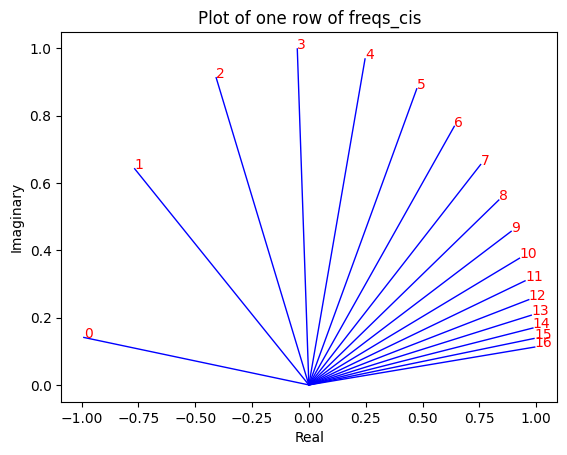

In [28]:
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

In [29]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_per_token_as_complex_numbers = q_per_token_as_complex_numbers.to(device)
freqs_cis = freqs_cis.to(device)
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 64])

In [34]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [35]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([17, 128])

In [36]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [37]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [38]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([17, 128])

In [39]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [40]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [41]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [42]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([17, 128])

In [43]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([17, 17])

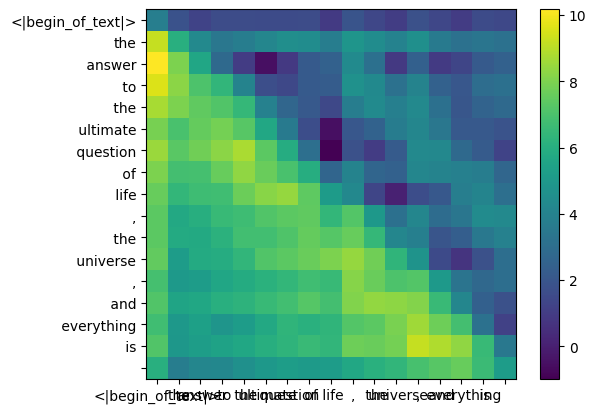

In [49]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.cpu().to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)

display_qk_heatmap(qk_per_token)

In [51]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

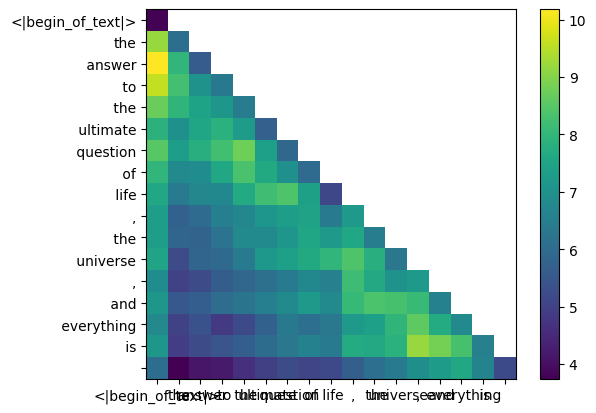

In [54]:
qk_per_token = qk_per_token.cpu()
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

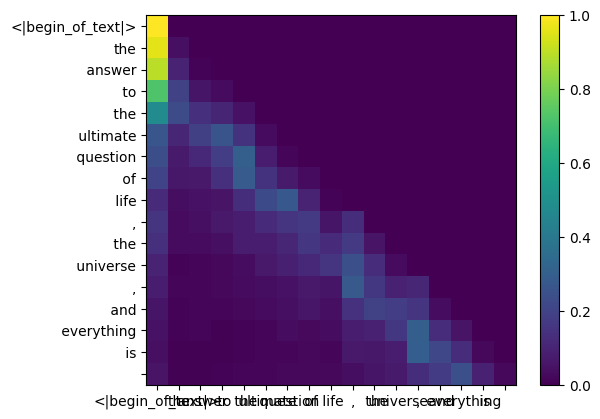

In [55]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

In [56]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 128, 4096])

In [57]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

In [58]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([17, 128])

In [62]:
v_per_token = v_per_token.cpu()
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([17, 128])

In [71]:
qkv_attention_store = []
for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token.cpu() + mask.cpu()
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax.cpu(), v_per_token.cpu())
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax.cpu(), v_per_token.cpu())
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

In [72]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 4096])

In [73]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

In [80]:
stacked_qkv_attention = stacked_qkv_attention.cpu()
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T.cpu())
embedding_delta.shape

torch.Size([17, 4096])

In [83]:
token_embeddings_unnormalized = token_embeddings_unnormalized.cpu()
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 4096])

In [86]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit.cpu(), model["layers.0.ffn_norm.weight"].cpu())
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

In [89]:
embedding_after_edit_normalized = embedding_after_edit_normalized.cpu()
w1 = model["layers.0.feed_forward.w1.weight"].cpu()
w2 = model["layers.0.feed_forward.w2.weight"].cpu()
w3 = model["layers.0.feed_forward.w3.weight"].cpu()
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([17, 4096])

In [90]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 4096])

In [104]:
final_embedding = token_embeddings_unnormalized
final_embedding.cpu()
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"].cpu())
    layer_embedding_norm = layer_embedding_norm.cpu()
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T.cpu())
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T.cpu())
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T.cpu())
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers.cpu() * freqs_cis.cpu())
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers.cpu() * freqs_cis.cpu())
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention.cpu(), w_layer.T.cpu())
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit.cpu(), model[f"layers.{layer}.ffn_norm.weight"].cpu())
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized.cpu(), w1.T.cpu())) * torch.matmul(embedding_after_edit_normalized.cpu(), w3.T.cpu()), w2.T.cpu())
    final_embedding = embedding_after_edit+output_after_feedforward

In [107]:
final_embedding = rms_norm(final_embedding, model["norm.weight"].cpu())
final_embedding.shape

torch.Size([17, 4096])

In [108]:
model["output.weight"].shape

torch.Size([128256, 4096])

In [110]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T.cpu())
logits.shape

torch.Size([128256])

In [111]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

In [112]:
tokenizer.decode([next_token.item()])

'42'